# Exploring the effect of survivorship bias mitigation on the performance of a recidivism prediction tool 

This code is part of the bachelor thesis *Exploring the effect of survivorship bias mitigation on the performance of a recidivism prediction tool* of Ninande Vermeer (student number 11269057) of the University of Amsterdam, in cooperation with KPMG.

The code is inspired on the findings of Wilson Pok (https://www.ambiata.com/blog/2019-12-13-bias-detection-and-mitigation/ (Wilson Pok, 13 Dec 2019, Ambiata)).

## Document setup

Download or clone the AI Fairness 360 toolkit of IBM on Github: https://github.com/IBM/AIF360. Position this prototype file within the aif360(-master) folder.

Make sure that pandas, numpy, matplotlib and sklearn are accessible and import all necessary packages. 

### Import necessary files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer
from aif360.algorithms.preprocessing import Reweighing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
np.random.seed(1)

## 1. Functions overview

This chapter contains all functions. It is divided in several sections explained below.

1. *Synthetic dataset* contains all functions about generating and merging datasets.
2. *Convert synthetic dataset to AIF360 format*  contains a function to convert a onehot encoded dataframe into a BinaryLabelDataset object of the AI Fairness 360 toolkit.
3. *Machine learning* consists of 3 subsections that consists of 1) aid functions, 2) a function to perform one machine learning loop and 3) functions to do multiple machine learning loops to obtain a mean result.
4. *Visualisation* contains all functions involved in visualising the dataset and results.
5. *Conditional probabilities* contains the functions to calculate probabilities.

All functions have a small documentation paragraph that explaines its input and the output details.

### 1.1. Synthetic dataset

In [2]:
''' CREATE DATASET
Input:  n_people (amount of people in dataset), 
        p_male (percentage of men in dataset),
        risk_male (percentage of men classified as high risk),
        risk_female (percentage of women classified as high risk)
Output: df, df_onehot (dataframe and the onehot encoded dataframe)
'''
def synthesize_data(n_people, p_male, risk_male, risk_female):
    p_female = 1 - p_male

    # Creating list with gender according to ratio
    gender = np.random.choice(['male', 'female'], size=n_people, p=[p_male, p_female])

    # Creating a dataframe using the list with genders
    df = pd.DataFrame({'gender' : gender})

    # Giving each individual a risk rate (1 = high, 0 = low) according to the high risk ratio
    df.loc[df.gender == 'male', 'risk'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'male']), p=[risk_male , 1 - risk_male])
    df.loc[df.gender == 'female', 'risk'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'female']), p=[risk_female, 1 - risk_female])

    df['risk'] = df['risk'].astype(int)
    
    # Encode to make gender readable for AIF360
    df_onehot = pd.concat([df[['risk']], pd.get_dummies(df[['gender']])], axis=1)
    
    return df, df_onehot

''' CREATE DATASET WITH NOISE
--> Adds the attributes 'age', 'educational level', 'crime rate' and 'family history' to the dataset
Input:  n_people (amount of people in dataset), 
        p_male (percentage of men in dataset),
        risk_male (percentage of men classified as high risk),
        risk_female (percentage of women classified as high risk)
Output: df, df_onehot (dataframe and the onehot encoded dataframe)
'''
def synthesize_data_with_noise(n_people, p_male, risk_male, risk_female):
    p_female = 1 - p_male

    # Creating list with gender according to ratio
    gender = np.random.choice(['male', 'female'], size=n_people, p=[p_male, p_female])

    # Creating a dataframe using the list with genders
    df = pd.DataFrame({'gender' : gender})

    # Giving each individual a risk rate (1 = high, 0 = low) according to the high risk ratio
    df.loc[df.gender == 'male', 'risk'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'male']), p=[risk_male , 1 - risk_male])
    df.loc[df.gender == 'female', 'risk'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'female']), p=[risk_female, 1 - risk_female])

    df['risk'] = df['risk'].astype(int)
    
    # Giving each individual an age
    mu, sigma = 45, 8
    
    df.loc[df.risk == 1, 'age'] = np.floor(np.random.normal(mu, sigma, len(df.loc[df.risk == 1])))
    df.loc[df.risk == 0, 'age'] = np.floor(np.random.normal(mu, sigma, len(df.loc[df.risk == 0])))
    
    df['age'] = df['age'].astype(int)
    
    # Giving each individual an educational level
    edu_levels = ['A', 'B', 'C', "D"]
    edu_chance = [0.25, 0.25, 0.25, 0.25]
    
    df.loc[df.gender == 'male', 'education'] = np.random.choice(edu_levels, size=len(df.loc[df.gender == 'male']), p=edu_chance)
    df.loc[df.gender == 'female', 'education'] = np.random.choice(edu_levels, size=len(df.loc[df.gender == 'female']), p=edu_chance)
    
    # Assigning a criminal degree to their crimes
    crime_rate = [1, 2, 3, 4]
    crime_chance = [0.25, 0.25, 0.25, 0.25]
    
    df.loc[df.gender == 'male', 'crime rate'] = np.random.choice(crime_rate, size=len(df.loc[df.gender == 'male']), p=crime_chance)
    df.loc[df.gender == 'female', 'crime rate'] = np.random.choice(crime_rate, size=len(df.loc[df.gender == 'female']), p=crime_chance)
    
    df['crime rate'] = df['crime rate'].astype(int)
    
    # Do their family have a criminal history
    df.loc[df.gender == 'male', 'family history'] = np.random.choice([0, 1], size=len(df.loc[df.gender == 'male']), p=[0.5, 0.5])
    df.loc[df.gender == 'female', 'family history'] = np.random.choice([0, 1], size=len(df.loc[df.gender == 'female']), p=[0.5, 0.5])
    
    df['family history'] = df['family history'].astype(int)   
    
    # Encode to make gender readable for AIF360
    df_onehot = pd.concat([df[['risk']], df[['age']], df[['crime rate']], df[['family history']], pd.get_dummies(df[['gender', 'education']])], axis=1)
    
    return df, df_onehot

In [3]:
''' SUBSET REALITY (substracts the new individuals from reality) 
Input:  df_reality (onehot encoded reality dataset),
        predicted_labels (predicted risk labels by trained model),
        fracs (tuple containing the percentage to substract of each group: 
        1. men with low risk, 
        2. men with high risk, 
        3. women with low risk, 
        4. women with high risk)
Output: df_new (the new entities in an onehot encoded dataset)
'''
def subset_reality(df_reality, predicted_labels, fracs):
    frac_m_0, frac_m_1, frac_f_0, frac_f_1 = fracs
    
    # Add predicted labels to reality Dataframe
    df_reality['predicted_label'] = predicted_labels.tolist()
    df_reality['predicted_label'] = df_reality['predicted_label'].astype(int)
    
    # Divide reality Dataframe into separate male and female datasets
    df_male = df_reality[df_reality.gender_female == 0]
    df_female = df_reality[df_reality.gender_female == 1]
    
    # Divide male and female datasets into separate high and low risk subsets
    df_male_0 = df_male[df_male.predicted_label == 0]
    df_male_1 = df_male[df_male.predicted_label == 1]
    df_female_0 = df_female[df_female.predicted_label == 0]
    df_female_1 = df_female[df_female.predicted_label == 1]

    # Take samples from the 4 subsets (and prevent sampling from empty list)
    subsets = []
    if df_male_0.empty != True: 
        df_m_0 = df_male_0.sample(frac=frac_m_0, random_state=1)
        subsets.append(df_m_0)
    if df_male_1.empty != True: 
        df_m_1 = df_male_1.sample(frac=frac_m_1, random_state=1)
        subsets.append(df_m_1)  
    if df_female_0.empty != True: 
        df_f_0 = df_female_0.sample(frac=frac_f_0, random_state=1)
        subsets.append(df_f_0)  
    if df_female_1.empty != True: 
        df_f_1 = df_female_1.sample(frac=frac_f_1, random_state=1)
        subsets.append(df_f_1)
    
    # Merge all samples together
    df_merge = pd.concat(subsets)
    
    # Reset index
    new = df_merge.reset_index(drop=True)
    
    # Drop predicted labels
    df_new = new.drop(['predicted_label'], axis=1)
    
    return df_new

### 1.2. Convert synthetic dataset to AIF360 format

In [4]:
''' CONVERTING ONEHOT ENCODED DATAFRAME TO AIF360 DATASET OBJECT
Input:  df_onehot (onehot encoded dataframe)
Output: df_aif (BinaryLabelDataset object),
        privileged_group (men)
        unprivileged_group (women)
'''
def convert_aif360(df_onehot):
    # Convert the dataset to a BinaryLabelDataset
    df_aif = BinaryLabelDataset(df=df_onehot.drop('gender_female', axis=1), label_names=['risk'], protected_attribute_names=['gender_male'])

    # Define privileged (females) and unprivileged (males) group
    priv_group = [{'gender_male': 0}] 
    unpriv_group = [{'gender_male': 1}] 
    
    return df_aif, priv_group, unpriv_group

### 1.3. Machine Learning

#### 1.3.1. Aid functions

In [5]:
# TRAINING
''' TRAIN LINEAR REGRESSION MODEL
Input:  dataset (BinaryLabelDataset object)
Output: model (trained model),
        scale (scale of the model)
'''
def train_linear_regression(dataset):
    scale = StandardScaler().fit(dataset.features)
    model = LogisticRegression(random_state=0, solver='liblinear')
    x_train = scale.transform(dataset.features)
    y_train = dataset.labels.ravel()
    model.fit(x_train, y_train, sample_weight=dataset.instance_weights)
    return model, scale

# VALIDATION
''' RETURN PROBABILITIES OF THE PREDICTED RISK
Input:  dataset (BinaryLabelDataset object),
        model (trained linear regression model),
        scale (scale of the trained model)
Output: label_prob (the probability of the predicted risk 
        (for a predicted risk of 0 and 1 respectively))
'''
def pred_prob_label(dataset, model, scale):
    x_test = scale.transform(dataset.features)
    label_prob = model.predict_proba(x_test)
    return label_prob

''' GET BEST THRESHOLD 
Input:  dataset (BinaryLabelDataset object),
        label_probs (the probabilities of the predicted risk values),
        thresholds (probable thresholds),
        priv (privileged group),
        unpriv (unprivileged group)
Output: best_accuracy (highest obtained accuracy score),
        best_threshold (threshold corresponding to the highest accuracy)
'''
def get_best_thresh(dataset, label_probs, thresholds, priv, unpriv):
    accuracies = []

    # Calculate accuracy for each threshold value
    for thresh in thresholds:
        y_validate_pred = (label_probs[:,1] > thresh).astype(np.double)
        dataset_pred = dataset.copy()
        dataset_pred.labels = y_validate_pred

        metric = ClassificationMetric(dataset, dataset_pred, unpriv, priv)
        acc = metric.accuracy()
        accuracies.append(acc)

    # Find threshold for best accuracy
    threshold_best_index = np.where(accuracies == np.max(accuracies))[0][0]
    best_threshold = np.array(thresholds)[threshold_best_index]

    # Find accuracy at this threshold
    best_accuracy = accuracies[threshold_best_index]

    return best_accuracy, best_threshold

''' VALIDATE MODEL
Input:  dataset (BinaryLabelDataset object),
        lr_model (trained linear regression model),
        lr_scale (scale of the trained model)
        priv (privileged group),
        unpriv (unprivileged group)
Output: best_acc (best obtained accuracy),
        best_thres (threshold used for the best accuracy score)
'''
def validate(dataset, lr_model, lr_scale, priv, unpriv):
    thresholds = np.linspace(0.01, 0.5, 100)
    label_probs = pred_prob_label(dataset, lr_model, lr_scale)
    best_acc, best_thres = get_best_thresh(dataset, label_probs, thresholds, priv, unpriv)   
    return best_acc, best_thres

# TESTING
''' TEST MODEL
Input:  dataset (BinaryLabelDataset object),
        lr_model (trained linear regression model),
        lr_scale (scale of model),
        best_thres (threshold used for the best accuracy score),
        priv (privileged group),
        unpriv (unprivileged group)
Output: class_metric (ClassificationMetric),
        dataset_pred (predicted dataset)
'''
def test(dataset, lr_model, lr_scale, best_thres, priv, unpriv):
    # Get label probabilities
    label_probs = pred_prob_label(dataset, lr_model, lr_scale)
    
    # Use best threshold to test model
    y_pred = (label_probs[:,1] > best_thres).astype(np.double)
    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
    
    # Get ClassificationMetric
    class_metric = ClassificationMetric(dataset, dataset_pred, unpriv, priv)
    
    return class_metric, dataset_pred

#### 1.3.2. One loop

In [6]:
''' MACHINE LEARNING
Input:  df_aif (BinaryLabelDataset object),
        trn_val_tst_ratio (ratio for training, validation and test set),
        priv (privileged group),
        unpriv (unprivileged group),
        reweigh ('yes' means using the reweighing algorithm)
Output: lr_model (trained model), 
        lr_scale (scale of trained model), 
        best_thres (threshold used to obtain the highest accuracy score in validation), 
        class_metric_tst (ClassificationMetric of the test set),
        result_round (List with the real and predicted amounts for the
        1. total low risk labeled individuals, 
        2. low risk labeled women, 
        3. low risk labeled men,
        4. total high risk labeled individuals,
        5. high risk labeled women,
        6. high risk labeled men)
'''
def learning_loop(df_aif, trn_val_tst_ratio, priv, unpriv, reweigh='no'):
    df_trn, df_val, df_tst = df_aif.split(trn_val_tst_ratio, shuffle=True)
    
    # Training with reweighing
    if reweigh == 'yes':
        # Create reweighing obejct
        RW = Reweighing(unprivileged_groups=unpriv, privileged_groups=priv)

        # Reweigh the training dataset
        RW.fit(df_trn) 
        df_transf_trn = RW.transform(df_trn)

        # First fairness metrics
        metric_trn = BinaryLabelDatasetMetric(df_transf_trn, unpriv, priv)
        
        # Training the model
        lr_model, lr_scale = train_linear_regression(df_transf_trn)

    # Training without reweighing
    else:
        # TRAINING
        # First fairness metrics
        metric_trn = BinaryLabelDatasetMetric(df_trn, unpriv, priv)

        # Training the model
        lr_model, lr_scale = train_linear_regression(df_trn)

    # VALIDATION
    best_acc, best_thres = validate(df_val, lr_model, lr_scale, priv, unpriv)
    
    #print("best threshold", best_thres)
    #best_thres = 0.5

    # TESTING
    class_metric_tst, dataset_pred = test(df_tst, lr_model, lr_scale, best_thres, priv, unpriv)
    
    bin_metrics = BinaryLabelDatasetMetric(df_tst, unpriv, priv)
    bin_metrics_pred = BinaryLabelDatasetMetric(dataset_pred, unpriv, priv)
    
    # Collecting real amount of high and low risk labels
    low_risk_all = bin_metrics.num_negatives()
    low_risk_priv = bin_metrics.num_negatives(privileged=True)
    low_risk_unpriv = bin_metrics.num_negatives(privileged=False)
    high_risk_all = bin_metrics.num_positives()
    high_risk_priv = bin_metrics.num_positives(privileged=True)
    high_risk_unpriv = bin_metrics.num_positives(privileged=False)
    
    # Collecting prediction amount of high and low risk labels
    low_risk_all_pred = bin_metrics_pred.num_negatives()
    low_risk_priv_pred = bin_metrics_pred.num_negatives(privileged=True)
    low_risk_unpriv_pred = bin_metrics_pred.num_negatives(privileged=False)
    high_risk_all_pred = bin_metrics_pred.num_positives()
    high_risk_priv_pred = bin_metrics_pred.num_positives(privileged=True)
    high_risk_unpriv_pred = bin_metrics_pred.num_positives(privileged=False)
    
    # Combine real and predicted amounts
    result_low_all = [low_risk_all, low_risk_all_pred]
    result_low_priv = [low_risk_priv, low_risk_priv_pred]
    result_low_unpriv = [low_risk_unpriv, low_risk_unpriv_pred]
    result_high_all = [high_risk_all, high_risk_all_pred]
    result_high_priv = [high_risk_priv, high_risk_priv_pred]
    result_high_unpriv = [high_risk_unpriv, high_risk_unpriv_pred]
    
    result_round = [result_low_all, result_low_priv, result_low_unpriv, result_high_all, result_high_priv, result_high_unpriv]

    return lr_model, lr_scale, best_thres, class_metric_tst, result_round

#### 1.3.3. Multiple loops

In [7]:
''' PROCESS SIMULATION
Input:  N (amount of loops),
        df_onehot (onehot encoded dataframe),
        trn_val_tst_ratio (ratio for training, validation and test set),
        data_settings (tuple: n_people, p_male, risk_male, risk_female, fracs),
        reweigh ('yes' means using the reweighing algorithm),
        noise ('yes' means adding noise while generating the dataset)
Output: ACC (list of accuracies of test set)
        amounts (the percentage high/low risk labeled men/women in the dataset)
        results (list with real and predicted numbers of high and low risk labeled individuals)
        thresholds (list of the best thresholds)
'''
def multiple_learning(N, df_onehot, trn_val_tst_ratio, data_settings, reweigh='no', noise='yes'):
    i = 0
    
    n_people, p_male, risk_male, risk_female, fracs = data_settings
    
    ACC = []
    female_1 = []
    female_0 = []
    male_1 = []
    male_0 = []
    results = []
    thresholds = []
    
    while i < N:
        i += 1
        
        pivot_table = df_onehot.pivot_table(index='risk', columns='gender_male', aggfunc='size')
        total = pivot_table[0][1] + pivot_table[0][0] + pivot_table[1][1] + pivot_table[1][0]
        female_1.append((pivot_table[0][1]/total)*100)
        female_0.append((pivot_table[0][0]/total)*100)
        male_1.append((pivot_table[1][1]/total)*100)
        male_0.append((pivot_table[1][0]/total)*100)
        
        # Get trained model with the current dataset (df_onehot)
        df_aif, priv, unpriv = convert_aif360(df_onehot)
        metric_aif = BinaryLabelDatasetMetric(df_aif, unpriv, priv)
        lr_model, lr_scale, best_thres, class_metric_tst, result_round = learning_loop(df_aif, trn_val_tst_ratio, priv, unpriv, reweigh)
        
        # Append the results for current round to the list of results
        results.append(result_round)
        
        # Append the best threshold for each round to the thresholds list
        thresholds.append(best_thres)
        
        # Add new individuals to the dataset for the next round
        ## Create reality dataset
        if noise == 'yes':
            _, df_reality = synthesize_data_with_noise(n_people, p_male, risk_male, risk_female)
        else:
            _, df_reality = synthesize_data(n_people, p_male, risk_male, risk_female)
            
        df_reality_aif360, _, _ = convert_aif360(df_reality)
        
        ## Use trained model to predict the risk
        _, dataset_pred = test(df_reality_aif360, lr_model, lr_scale, best_thres, priv, unpriv)
        
        ## Get subset (arrested individuals) of reality
        df_new = subset_reality(df_reality, dataset_pred.labels, fracs)
        
        ## Merge subset with the dataset
        df_onehot = df_onehot.append(df_new)
        df_onehot = df_onehot.reset_index(drop=True)
            
        ACC.append(class_metric_tst.accuracy().round(3))
        
    amounts = [female_1, male_1, female_0, male_0]
    
    return ACC, amounts, results, thresholds

In [8]:
''' PROCESS SIMULATION MEAN
Input:  M (amount of simulations)
        N (amount of loops),
        df_general (onehot encoded dataframe),
        trn_val_tst_ratio (ratio for training, validation and test set),
        data_settings (tuple: n_people, p_male, risk_male, risk_female, fracs),
        reweigh ('yes' means using the reweighing algorithm),
        noise ('yes' means adding noise while generating the dataset)
Output: ACC_mean (accuracy of test set)
        amounts_mean (mean of percentages of high/low risk labeled men/women)
        np.round(results_mean,0) (mean of amounts of total high/low risk labeled individuals/men/women, 0 decimals)
        np.round(thresholds_mean,3) (mean of the best thresholds, 3 decimales)
'''
def multiple_learning_mean(M, N, df_general, trn_val_tst_ratio, data_settings, reweigh='no', noise='yes'):
    i = 0 
    
    ACC_all = []
    amounts_all = []
    results_all = []
    thresholds_all = []
    
    if reweigh == 'no':
        print("Machine learning without reweighing")
    else:
        print("Machine learning with reweighing")
    
    while i < M:
        i += 1
        print("round", i)
        ACC, amounts, results, thresholds = multiple_learning(N, df_general, trn_val_tst_ratio, data_settings, reweigh, noise)
        ACC_all.append(ACC)
        amounts_all.append(amounts)
        results_all.append(results)
        thresholds_all.append(thresholds)
    
    ACC_mean = np.mean(ACC_all, axis=0)
    amounts_mean = np.mean(amounts_all, axis=0)
    results_mean = np.mean(results_all, axis=0)
    thresholds_mean = np.mean(thresholds_all, axis=0)
    
    return ACC_mean, amounts_mean, np.round(results_mean,0), np.round(thresholds_mean,3)
    

### 1.4 Visualisation

In [9]:
''' ATTACH LABEL TO BAR(S) IN BARPLOT DISPLAYING ITS HEIGHT VALUE
input:  ax (barplot),
        brs (one or several bars)
output: text labels on bars on the ax barplot
'''
def bar_label(ax, brs, dec='.3f'):
    for br in brs:
        height = br.get_height()
        ax.annotate(format(height, dec),
                    xy=(br.get_x() + br.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
''' VISUALISING FAIRNESS METRICS: ACCURACY
Input:  result (list containing lists with AOD, ACC, PREC and REC for respectively without and with reweighing),
Output: Barplot of the accuracy
'''
def visualise_result(result):
    N = len(result)
    x = np.arange(1, N+1) 
    
    x_labels = ()    
    for i in x:
        x_labels = x_labels[:] + (str(i),)
    
    bar_width = 0.4
    
    fig, ax = plt.subplots()
    br = ax.bar(x, result, bar_width)
    ax.set_title('Accuracy')
    ax.set_xlabel('# rounds')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_ybound(0, 1)
    
    bar_label(ax, br)

''' VISUALISE THE PERCENTAGES OF HIGH/LOW RISK LABELED MEN/WOMEN IN DATASET
Input: amounts (percentages in list of
        1. women with high risk label,
        2. men with high risk label,
        3. women with low risk label,
        4. men with low risk label)
Output: barplot of the amounts
'''
def visualise_amounts(amounts):
    female_1 = amounts[0]
    male_1 = amounts[1]
    female_0 = amounts[2]
    male_0 = amounts[3]
    
    N = len(female_1)
    x = np.arange(1, N+1) 
    
    x_labels = ()    
    for i in x:
        x_labels = x_labels[:] + (str(i),)
    
    bar_width = 0.2
    
    fig, ax = plt.subplots()
    br1 = ax.bar(x-1.5*bar_width, female_1, bar_width, color='darkorchid')
    br2 = ax.bar(x-0.5*bar_width, female_0, bar_width, color='pink')
    br3 = ax.bar(x+0.5*bar_width, male_1, bar_width, color='navy')
    br4 = ax.bar(x+1.5*bar_width, male_0, bar_width, color='royalblue')
    ax.set_title('Amounts')
    ax.set_xlabel('# rounds')
    ax.set_ylabel('Percentage of total amount of people')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    
    bar_label(ax, br1, '.0f')
    bar_label(ax, br2, '.0f')
    bar_label(ax, br3, '.0f')
    bar_label(ax, br4, '.0f')

### 1.5 Conditional Probabilities

In [10]:
''' CALCULATE CONDITIONAL PROBABILITIES
Based on the calculation posed in the thesis.
'''
# Calculate probability Arrested, given Gender and Risk score
def cal_A_given_G_and_R(P_A, P_G, P_A_given_G, P_R_given_A):
    P_G_and_R_given_A = cal_G_and_R_given_A(P_G, P_A_given_G, P_R_given_A, P_A)
    P_G_and_R = cal_G_and_R(P_G_and_R_given_A, P_A, P_G, P_A_given_G, P_R_given_A)
    
    return (P_G_and_R_given_A * P_A) / P_G_and_R
    
## Calculate probability Gender and Risk, given Arrested
def cal_G_and_R_given_A(P_G, P_A_given_G, P_R_given_A, P_A):
    P_R_given_G_and_A = cal_R_given_G_and_A(P_G, P_A_given_G, P_R_given_A)
    P_G_given_A = cal_G_given_A(P_A_given_G, P_G, P_A)
    
    return P_R_given_G_and_A * P_G_given_A 

### Calculate probability Risk, given Gender and Arrested
def cal_R_given_G_and_A(P_G, P_A_given_G, P_R_given_A):
    return P_G * P_A_given_G * P_R_given_A
    
### Calculate probability Gender, given Arrested
def cal_G_given_A(P_A_given_G, P_G, P_A):
    return (P_A_given_G * P_G) / P_A

## Calculate joint probability Gender and Risk
def cal_G_and_R(P_G_and_R_given_A, P_A, P_G, P_A_given_G, P_R_given_A):
    P_A_c = 1 - P_A
    P_A_c_given_G = 1 - P_A_given_G
    
    P_G_and_R_given_A_c = cal_G_and_R_given_A_c(P_G, P_A_c, P_A_c_given_G, P_R_given_A)
    
    return P_G_and_R_given_A * P_A + P_G_and_R_given_A_c * P_A_c  

### Calculate Gender and Risk, given not Arrested
def cal_G_and_R_given_A_c(P_G, P_A_c, P_A_c_given_G, P_R_given_A):
    P_R_given_A_c = 1 - P_R_given_A
    P_R_given_G_and_A_c = cal_R_given_G_and_A(P_G, P_A_c_given_G, P_R_given_A_c)
    
    P_G_given_A_c = cal_G_given_A(P_A_c_given_G, P_G, P_A_c)
    
    return P_R_given_G_and_A_c * P_G_given_A_c

def get_fracs(P_A, P_M, P_F, P_A_given_M, P_A_given_F, P_1_given_A, P_0_given_A):
    P_A_given_M_and_1 = cal_A_given_G_and_R(P_A, P_M, P_A_given_M, P_1_given_A)
    P_A_given_M_and_0 = cal_A_given_G_and_R(P_A, P_M, P_A_given_M, P_0_given_A)
    P_A_given_F_and_1 = cal_A_given_G_and_R(P_A, P_F, P_A_given_F, P_1_given_A)
    P_A_given_F_and_0 = cal_A_given_G_and_R(P_A, P_F, P_A_given_F, P_0_given_A)
    
    return (P_A_given_M_and_0, P_A_given_M_and_1, P_A_given_F_and_0, P_A_given_F_and_1)

# 2 Scenario's

By altering risk_male, risk_female and noise it is possible to retrieve the results of the thesis.

## 2.1 General dataset

In [11]:
# SETTINGS
noise = 'yes'
n_people = 10000
p_male = 0.6
risk_male = 0.7 
risk_female = 0.5

# Creating dataset
if noise == 'yes':
    df, df_general = synthesize_data_with_noise(n_people, p_male, risk_male, risk_female)
else:
    df, df_general = synthesize_data(n_people, p_male, risk_male, risk_female)

In [12]:
np.set_printoptions(suppress=True)

## 2.2 Realities

### 2.2.1 Survivorship bias

In [13]:
# SETTINGS
n_people_new = 500
p_male_new = 0.5
risk_male_new = 0.5 
risk_female_new = 0.5

P_A = 2/3
P_M = 1/2
P_F = 1/2
P_A_given_M = 3/5
P_A_given_F = 1/2
P_1_given_A = 7/10
P_0_given_A = 1/2

fracs = get_fracs(P_A, P_M, P_F, P_A_given_M, P_A_given_F, P_1_given_A, P_0_given_A)
print("Percentages to substract from reality (men low/high risk, women low/high risk)", fracs)
trn_val_tst_ratio = [0.5, 0.8]

data_settings = (n_people_new, p_male_new, risk_male_new, risk_female_new, fracs)

Percentages to substract from reality (men low/high risk, women low/high risk) (0.6923076923076923, 0.8400000000000001, 0.5, 0.7)


#### 2.2.1.1 Without debiasing

Machine learning without reweighing
round 1
round 2
round 3
round 4
round 5
round 6
round 7
round 8
round 9
round 10
round 11
round 12
round 13
round 14
round 15
round 16
round 17
round 18
round 19
round 20
round 21
round 22
round 23
round 24
round 25
round 26
round 27
round 28
round 29
round 30
round 31
round 32
round 33
round 34
round 35
round 36
round 37
round 38
round 39
round 40
round 41
round 42
round 43
round 44
round 45
round 46
round 47
round 48
round 49
round 50
round 51
round 52
round 53
round 54
round 55
round 56
round 57
round 58
round 59
round 60
round 61
round 62
round 63
round 64
round 65
round 66
round 67
round 68
round 69
round 70
round 71
round 72
round 73
round 74
round 75
round 76
round 77
round 78
round 79
round 80
round 81
round 82
round 83
round 84
round 85
round 86
round 87
round 88
round 89
round 90
round 91
round 92
round 93
round 94
round 95
round 96
round 97
round 98
round 99
round 100


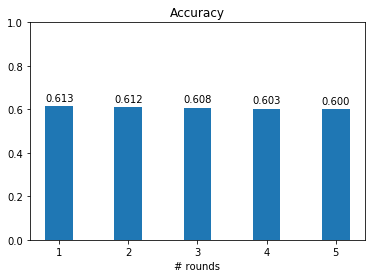

In [14]:
ACC_mean_R1_Without, amounts_R1_without, results_mean, thresholds_mean = multiple_learning_mean(100, 5, df_general, trn_val_tst_ratio, data_settings, 'no', noise)
visualise_result(ACC_mean_R1_Without)

In [15]:
print(results_mean)
print(thresholds_mean)

[[[ 776.  279.]
  [ 401.  279.]
  [ 376.    0.]
  [1224. 1721.]
  [ 389.  511.]
  [ 834. 1210.]]

 [[ 810.  292.]
  [ 413.  292.]
  [ 397.    0.]
  [1264. 1782.]
  [ 406.  526.]
  [ 858. 1255.]]

 [[ 846.  281.]
  [ 431.  281.]
  [ 415.    0.]
  [1301. 1866.]
  [ 420.  571.]
  [ 881. 1296.]]

 [[ 883.  298.]
  [ 446.  298.]
  [ 438.    0.]
  [1338. 1922.]
  [ 438.  585.]
  [ 900. 1338.]]

 [[ 922.  306.]
  [ 464.  306.]
  [ 458.    0.]
  [1372. 1989.]
  [ 452.  610.]
  [ 921. 1379.]]]
[0.469 0.468 0.463 0.455 0.467]


#### 2.2.1.2 With debiasing

Machine learning with reweighing
round 1
round 2
round 3
round 4
round 5
round 6
round 7
round 8
round 9
round 10
round 11
round 12
round 13
round 14
round 15
round 16
round 17
round 18
round 19
round 20
round 21
round 22
round 23
round 24
round 25
round 26
round 27
round 28
round 29
round 30
round 31
round 32
round 33
round 34
round 35
round 36
round 37
round 38
round 39
round 40
round 41
round 42
round 43
round 44
round 45
round 46
round 47
round 48
round 49
round 50
round 51
round 52
round 53
round 54
round 55
round 56
round 57
round 58
round 59
round 60
round 61
round 62
round 63
round 64
round 65
round 66
round 67
round 68
round 69
round 70
round 71
round 72
round 73
round 74
round 75
round 76
round 77
round 78
round 79
round 80
round 81
round 82
round 83
round 84
round 85
round 86
round 87
round 88
round 89
round 90
round 91
round 92
round 93
round 94
round 95
round 96
round 97
round 98
round 99
round 100


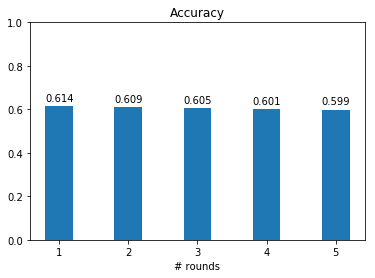

In [16]:
ACC_mean_R1_With, amounts_R1_with, results_mean, thresholds_mean = multiple_learning_mean(100, 5, df_general, trn_val_tst_ratio, data_settings, 'yes', noise)
visualise_result(ACC_mean_R1_With)

In [17]:
print(results_mean)
print(thresholds_mean)

[[[ 772.    0.]
  [ 399.    0.]
  [ 373.    0.]
  [1228. 2000.]
  [ 391.  790.]
  [ 837. 1210.]]

 [[ 813.    0.]
  [ 415.    0.]
  [ 397.    0.]
  [1265. 2077.]
  [ 406.  821.]
  [ 858. 1256.]]

 [[ 851.    0.]
  [ 434.    0.]
  [ 417.    0.]
  [1303. 2154.]
  [ 422.  856.]
  [ 881. 1298.]]

 [[ 890.    0.]
  [ 452.    0.]
  [ 438.    0.]
  [1341. 2231.]
  [ 442.  894.]
  [ 900. 1338.]]

 [[ 926.    0.]
  [ 468.    0.]
  [ 458.    0.]
  [1382. 2308.]
  [ 460.  928.]
  [ 923. 1381.]]]
[0.01 0.01 0.01 0.01 0.01]


### 2.2.2 Fair dataset

In [18]:
# SETTINGS
n_people_new = 500
p_male_new = 0.5
risk_male_new = 0.7 
risk_female_new = 0.5

P_A = 2/3
P_M = 1/2
P_F = 1/2
P_A_given_M = 1/2
P_A_given_F = 1/2
P_1_given_A = 7/10
P_0_given_A = 1/2

fracs = get_fracs(P_A, P_M, P_F, P_A_given_M, P_A_given_F, P_1_given_A, P_0_given_A)
print("Percentages to substract from reality (men low/high risk, women low/high risk)", fracs)
trn_val_tst_ratio = [0.5, 0.8]

data_settings = (n_people_new, p_male_new, risk_male_new, risk_female_new, fracs)

Percentages to substract from reality (men low/high risk, women low/high risk) (0.5, 0.7, 0.5, 0.7)


#### 2.2.2.1 Without debiasing

Machine learning without reweighing
round 1
round 2
round 3
round 4
round 5
round 6
round 7
round 8
round 9
round 10
round 11
round 12
round 13
round 14
round 15
round 16
round 17
round 18
round 19
round 20
round 21
round 22
round 23
round 24
round 25
round 26
round 27
round 28
round 29
round 30
round 31
round 32
round 33
round 34
round 35
round 36
round 37
round 38
round 39
round 40
round 41
round 42
round 43
round 44
round 45
round 46
round 47
round 48
round 49
round 50
round 51
round 52
round 53
round 54
round 55
round 56
round 57
round 58
round 59
round 60
round 61
round 62
round 63
round 64
round 65
round 66
round 67
round 68
round 69
round 70
round 71
round 72
round 73
round 74
round 75
round 76
round 77
round 78
round 79
round 80
round 81
round 82
round 83
round 84
round 85
round 86
round 87
round 88
round 89
round 90
round 91
round 92
round 93
round 94
round 95
round 96
round 97
round 98
round 99
round 100


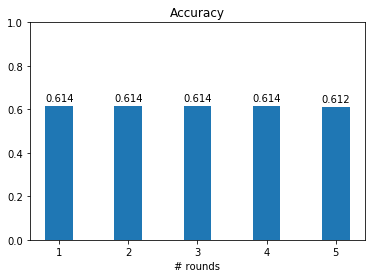

In [19]:
ACC_mean_R2_Without, _, results_mean, thresholds_mean = multiple_learning_mean(100, 5, df_general, trn_val_tst_ratio, data_settings, 'no', noise)
visualise_result(ACC_mean_R2_Without)

In [20]:
print(results_mean)
print(thresholds_mean)

[[[ 775.  268.]
  [ 399.  268.]
  [ 375.    0.]
  [1225. 1732.]
  [ 392.  523.]
  [ 834. 1209.]]

 [[ 801.  257.]
  [ 416.  257.]
  [ 385.    0.]
  [1266. 1810.]
  [ 405.  564.]
  [ 861. 1246.]]

 [[ 826.  297.]
  [ 430.  297.]
  [ 397.    0.]
  [1308. 1837.]
  [ 421.  553.]
  [ 887. 1284.]]

 [[ 853.  295.]
  [ 446.  295.]
  [ 407.    0.]
  [1347. 1905.]
  [ 436.  587.]
  [ 912. 1319.]]

 [[ 883.  293.]
  [ 465.  293.]
  [ 419.    0.]
  [1384. 1974.]
  [ 453.  625.]
  [ 931. 1350.]]]
[0.448 0.461 0.449 0.48  0.447]


#### 2.2.2.2 With debiasing

Machine learning with reweighing
round 1
round 2
round 3
round 4
round 5
round 6
round 7
round 8
round 9
round 10
round 11
round 12
round 13
round 14
round 15
round 16
round 17
round 18
round 19
round 20
round 21
round 22
round 23
round 24
round 25
round 26
round 27
round 28
round 29
round 30
round 31
round 32
round 33
round 34
round 35
round 36
round 37
round 38
round 39
round 40
round 41
round 42
round 43
round 44
round 45
round 46
round 47
round 48
round 49
round 50
round 51
round 52
round 53
round 54
round 55
round 56
round 57
round 58
round 59
round 60
round 61
round 62
round 63
round 64
round 65
round 66
round 67
round 68
round 69
round 70
round 71
round 72
round 73
round 74
round 75
round 76
round 77
round 78
round 79
round 80
round 81
round 82
round 83
round 84
round 85
round 86
round 87
round 88
round 89
round 90
round 91
round 92
round 93
round 94
round 95
round 96
round 97
round 98
round 99
round 100


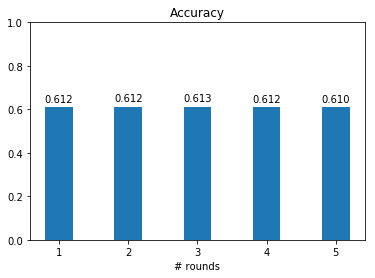

In [21]:
ACC_mean_R2_With, _, results_mean, thresholds_mean = multiple_learning_mean(100, 5, df_general, trn_val_tst_ratio, data_settings, 'yes', noise)
visualise_result(ACC_mean_R2_With)

In [22]:
print(results_mean)
print(thresholds_mean)

[[[ 776.    0.]
  [ 398.    0.]
  [ 377.    0.]
  [1224. 2000.]
  [ 391.  789.]
  [ 833. 1211.]]

 [[ 802.    0.]
  [ 418.    0.]
  [ 384.    0.]
  [1268. 2070.]
  [ 405.  823.]
  [ 863. 1247.]]

 [[ 828.    0.]
  [ 433.    0.]
  [ 396.    0.]
  [1312. 2140.]
  [ 424.  857.]
  [ 887. 1283.]]

 [[ 857.    0.]
  [ 452.    0.]
  [ 405.    0.]
  [1353. 2210.]
  [ 443.  895.]
  [ 910. 1315.]]

 [[ 889.    0.]
  [ 472.    0.]
  [ 417.    0.]
  [1391. 2280.]
  [ 458.  931.]
  [ 933. 1349.]]]
[0.01 0.01 0.01 0.01 0.01]
